# Lib Imports

In [1]:
pip install mlflow

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.0/17.0 MB 45.1 MB/s eta 0:00:0000:0100:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 82.7/82.7 kB 7.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.8/40.8 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 6.9 MB/s eta 0:00:00
  Created wheel for databricks-cli: filename=databricks_cli-0.17.6-py3-none-any.whl size=143241 sha256=4007fc6fe65ddc61474059efa1f8b2543b0ea2ac3e10b11228520a02a1cbc48a
  Stored in directory: /root/.cache/pip/wheels/15/b5/26/0fe17f6fc2cf206f657d177a68cebed422be876514f082187b
Successfully built databricks-cli
  Attempting uninstall: packaging
    Found existing installation: packaging 23.0
    Uninstalling packaging-23.0:
      Successfully uninstalled packaging-23.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depen

In [2]:
pip install numdifftools

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100.2/100.2 kB 3.3 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [3]:
import warnings
warnings.filterwarnings("ignore")

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/fgenerator/generator_1000.pth
/kaggle/input/generator/modelXG.pth
/kaggle/input/df-pca-n/df_pca_n.csv


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math

import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.autograd import grad as torch_grad
import torch.nn.functional as F
from torch.autograd import Variable

import xgboost as xgb

from sklearn.metrics import log_loss
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from scipy.interpolate import interp1d
from scipy.misc import derivative
import numdifftools as nd
from scipy.signal import argrelextrema

import optuna
import mlflow
from torch.optim.lr_scheduler import StepLR
from mlflow import pytorch
import datetime
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN

# Data Import

In [5]:
df=pd.read_csv("/kaggle/input/df-pca-n/df_pca_n.csv")
df.head()

,pca1,pca2,pca3,pca4,pca5,pca6,pca7,pca8,pca11,pca13,pca14,pca16,pca17,pca18,pca19,pca20,pca21,Close
0,8.744221,-0.658155,-1.093340,1.176938,-0.600751,0.026237,-0.359053,0.953242,-0.384168,-0.651644,1.318398,-1.074751,-0.619783,0.330380,0.079497,-0.023768,-0.397569,13761.50
1,8.735730,-1.444550,-0.894045,1.317192,-0.625199,0.668508,0.187651,0.723749,0.073215,-2.282633,0.713949,-1.182119,-0.148796,0.673623,0.072780,-0.063445,-0.497342,13792.66
2,8.766185,-1.117762,-0.750429,0.095987,-0.725724,0.366221,0.253420,0.077264,1.710729,0.324876,-0.788650,-1.095183,-0.214677,0.895774,0.097829,-0.167460,-0.486162,13792.35
3,8.713572,-1.480208,-1.114621,0.445480,-0.911416,2.514267,0.581901,-0.143601,0.889499,-0.816233,-0.254987,-1.091789,-0.075686,0.902458,0.077003,-0.013148,-0.541326,13799.99
4,8.754863,-1.396565,-0.814961,0.131886,-0.800946,3.031047,0.010632,1.081172,-0.577558,-0.129734,0.952726,-1.102891,-0.133230,0.951209,0.096098,-0.127653,-0.519283,13800.65


In [6]:
print(df.shape)

(209107, 18)


In [7]:
def NaNCheck(data):
  return data.isnull().sum()[data.isnull().sum()>0]

print(NaNCheck(df))

Series([], dtype: int64)


# Data Preprocess 

In [8]:
# def sliding_window(x, y, feature_window,label_window,trend_window):
#     x_ = []
#     y_ = []
#     y_gan_pr = []
#     y_gan_cl = []
#     y_gan_tr = []
#     for i in range(trend_window, x.shape[0]+feature_window-label_window+1):
#         tmp_x = x[i - feature_window: i, :]
#         tmp_y = y[i]
#         tmp_y_gan_pr = y[i - feature_window: i + 1]
#         tmp_y_gan_cl = y[i - feature_window: i + label_window-feature_window]
#         tmp_y_gan_tr = y[i - trend_window: i, :]
#         x_.append(tmp_x)
#         y_.append(tmp_y)
#         y_gan_pr.append(tmp_y_gan_pr)
#         y_gan_cl.append(tmp_y_gan_cl)
#         y_gan_tr.append(tmp_y_gan_tr)
#     x_ = torch.from_numpy(np.array(x_)).float()
#     y_ = torch.from_numpy(np.array(y_)).float()
#     y_gan_pr = torch.from_numpy(np.array(y_gan_pr)).float()
#     y_gan_cl = torch.from_numpy(np.array(y_gan_cl)).float()
#     y_gan_tr = torch.from_numpy(np.array(y_gan_tr)).float()
#     return x_, y_, y_gan_pr,y_gan_cl,y_gan_tr



def sliding_window(x, y, y_raw ,feature_window,label_window,trend_window):
    x_ = []
    y_ = []
    y_gan_pr = []
    y_gan_cl = []
    y_gan_tr = []
    backward_length = max(trend_window,label_window)
    for i in range(backward_length, x.shape[0]-label_window):
        tmp_x = x[i - feature_window: i, :]
        tmp_y = y[i]
        tmp_y_gan_pr = y[i - feature_window: i + 1]
        tmp_y_gan_cl = y_raw[i - label_window: i + label_window+1]
        tmp_y_gan_tr = y_raw[i - trend_window: i, :]
        x_.append(tmp_x)
        y_.append(tmp_y)
        y_gan_pr.append(tmp_y_gan_pr)
        y_gan_cl.append(tmp_y_gan_cl)
        y_gan_tr.append(tmp_y_gan_tr)
    x_ = torch.from_numpy(np.array(x_)).float()
    y_ = torch.from_numpy(np.array(y_)).float()
    y_gan_pr = torch.from_numpy(np.array(y_gan_pr)).float()
    y_gan_cl = torch.from_numpy(np.array(y_gan_cl)).float()
    y_gan_tr = torch.from_numpy(np.array(y_gan_tr)).float()
    return x_, y_, y_gan_pr,y_gan_cl,y_gan_tr



In [9]:
def trend_detection(data):
    n = data.shape[1]
    sets = data.shape[0]
    mean_derivatives = np.zeros((sets,1))
    
    data = data.numpy()

    for i in range(sets):
        # Select the i-th 20 set
        x = np.arange(1,n+1)
        x_fake = np.arange(1.1, n, 0.1)
        y = data[i, :, 0]
        # Simple interpolation of x and y    
        f = interp1d(x, y)
        
        # derivative of y with respect to x
        df_dx = nd.Derivative(f, step=1e-6)(x_fake)
        # Calculate the mean derivative for the i-th 20 set
        average = np.average(df_dx)
        mean_derivatives[i][0] = average
    return  torch.from_numpy(mean_derivatives)   

#### Constants

In [10]:
training_duration = 2016
testing_duration = 2016
smoothing_threshold = 0.01
sliding_window_size = 10
classification_label_size = 12
trend_measure_lenth = 12

#### Train test split

In [11]:
labels_df = df["Close"]
features_df = df.drop(columns=["Close"])

train_x = features_df.iloc[:training_duration]
train_y = labels_df.iloc[:training_duration]

test_x = features_df.iloc[training_duration:training_duration+testing_duration]
test_y = labels_df.iloc[training_duration:training_duration+testing_duration]

print(f'trainX: {train_x.shape} trainY: {train_y.shape}')
print(f'testX: {test_x.shape} testY: {test_y.shape}')


trainX: (2016, 17) trainY: (2016,)
testX: (2016, 17) testY: (2016,)


#### Smoothing Thresholds

In [12]:
# value_range = max(max(train_y),max(test_y)) - min(min(train_y),min(test_y))
# smoothing_threshold = smoothing_threshold/value_range
# print(smoothing_threshold)

#### Scalling

In [13]:
x_scaler = MinMaxScaler(feature_range = (0, 1))
y_scaler = MinMaxScaler(feature_range = (0, 1))
trend_scaler = MinMaxScaler(feature_range = (0, 1))

train_x = x_scaler.fit_transform(train_x)
test_x = x_scaler.transform(test_x)

raw_train_y = train_y.values.reshape(-1, 1)
raw_test_y = test_y.values.reshape(-1, 1)
train_y = y_scaler.fit_transform(train_y.values.reshape(-1, 1))
test_y = y_scaler.transform(test_y.values.reshape(-1, 1))

#### Dataset preparation

In [14]:
# For price prediction model
train_x_slide, train_y_slide, train_y_gan,train_y_gan_cl,train_direction_slide = sliding_window(train_x, train_y,raw_train_y, sliding_window_size,classification_label_size,trend_measure_lenth)                
test_x_slide, test_y_slide, test_y_gan,test_y_gan_cl,test_direction_slide = sliding_window(test_x, test_y, raw_test_y ,sliding_window_size,classification_label_size,trend_measure_lenth)

train_trend_features = trend_detection(train_direction_slide)
test_trend_features = trend_detection(test_direction_slide)
train_trend_features = torch.tensor(trend_scaler.fit_transform(train_trend_features))
test_trend_features = torch.tensor(trend_scaler.transform(test_trend_features))
new_feature_tensor_train = train_trend_features.repeat(1,10)
new_feature_tensor_train = new_feature_tensor_train.unsqueeze(2)
new_feature_tensor_test = test_trend_features.repeat(1,10)
new_feature_tensor_test = new_feature_tensor_test.unsqueeze(2)

print('For Price prediction')
print(f'train_x_slide: {train_x_slide.shape} train_y_slide: {train_y_slide.shape} train_y_gan: {train_y_gan.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_slide: {test_y_slide.shape} test_y_gan: {test_y_gan.shape}\n')

print('For Bottom classification')
print(f'train_x_slide: {train_x_slide.shape} train_y_gan_cl: {train_y_gan_cl.shape}')
print(f'test_x_slide: {test_x_slide.shape} test_y_gan_cl: {test_y_gan_cl.shape}\n')

print('For current trend calculation')
print(f'train_direction_slide: {train_direction_slide.shape} train_trend_features: {train_trend_features.shape} ')
print(f'test_direction_slide: {test_direction_slide.shape} test_trend_features: {test_trend_features.shape} ')

For Price prediction
train_x_slide: torch.Size([1992, 10, 17]) train_y_slide: torch.Size([1992, 1]) train_y_gan: torch.Size([1992, 11, 1])
test_x_slide: torch.Size([1992, 10, 17]) test_y_slide: torch.Size([1992, 1]) test_y_gan: torch.Size([1992, 11, 1])

For Bottom classification
train_x_slide: torch.Size([1992, 10, 17]) train_y_gan_cl: torch.Size([1992, 25, 1])
test_x_slide: torch.Size([1992, 10, 17]) test_y_gan_cl: torch.Size([1992, 25, 1])

For current trend calculation
train_direction_slide: torch.Size([1992, 12, 1]) train_trend_features: torch.Size([1992, 1]) 
test_direction_slide: torch.Size([1992, 12, 1]) test_trend_features: torch.Size([1992, 1]) 


# Model Implementation

### GAN Model

#### Generator

In [16]:
class Generator(nn.Module):
    
    def __init__(self, input_size):
        super().__init__()

        # 3 GRU layers, input_size = features
        self.gru_1 = nn.GRU(input_size, 1024, batch_first=True)
        self.gru_2 = nn.GRU(1024, 512, batch_first = True)
        self.gru_3 = nn.GRU(512, 256, batch_first = True)
        # 3 Dense Layers
        self.linear_1 = nn.Linear(256, 128)
        self.linear_2 = nn.Linear(128, 64)
        self.linear_3 = nn.Linear(64, 1)

        self.dropout = nn.Dropout(0.2)
        self.tanh = nn.Tanh()


    def forward(self, x,use_cuda=1):
        device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")
        h0 = torch.zeros(1, x.size(0), 1024).to(device) # initial hidden state for the 1st GRU Layer - (num of layers in the GRU, batch size, num of hidden units in the GRU)
        out_gru_1, _ = self.gru_1(x, h0)
        out_gru_1 = self.dropout(out_gru_1)

        h1 = torch.zeros(1, x.size(0), 512).to(device)
        out_gru_2, _ = self.gru_2(out_gru_1, h1)
        out_gru_2 = self.dropout(out_gru_2)

        h2 = torch.zeros(1, x.size(0), 256).to(device)
        out_gru_3, _ = self.gru_3(out_gru_2, h2)
        out_gru_3 = self.dropout(out_gru_3)

        out_dense_1 = self.linear_1(out_gru_3[:, -1, :])
        out_dense_2 = self.linear_2(out_dense_1)
        out_dense_3 = self.linear_3(out_dense_2)

        return out_dense_3,out_gru_3

### Classification Model - XGBoost

In [17]:
def find_bottom_point_labels_mean(y,slide):

    y1 = y[:, :slide, :] # 128,10,1
    y2 = y[:, slide+1:, :]
    values = y[:,slide,:]

    y_avg = torch.mean(y1,dim=1)
    y_next_avg = torch.mean(y2, dim=1)
    y_bool = y_avg>(y[:,slide,:] + smoothing_threshold) 
    y_next_bool = y_next_avg>(y[:,slide,:] + smoothing_threshold)
    result = np.logical_and(y_bool.numpy(), y_next_bool.numpy())
    y_label=np.where(result, 1, 0)
    
    index_val = np.where(y_label == 1)
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize=(15, 8))
    plt.plot(y[:,slide,:], zorder=0)
    plt.scatter(index_val[0], values[np.where(y_label == 1)],
      label='Minima', s=100, color=colors[1], marker='^')
    plt.legend()
    plt.show()

    y_labels = torch.from_numpy(y_label)

    return y_labels

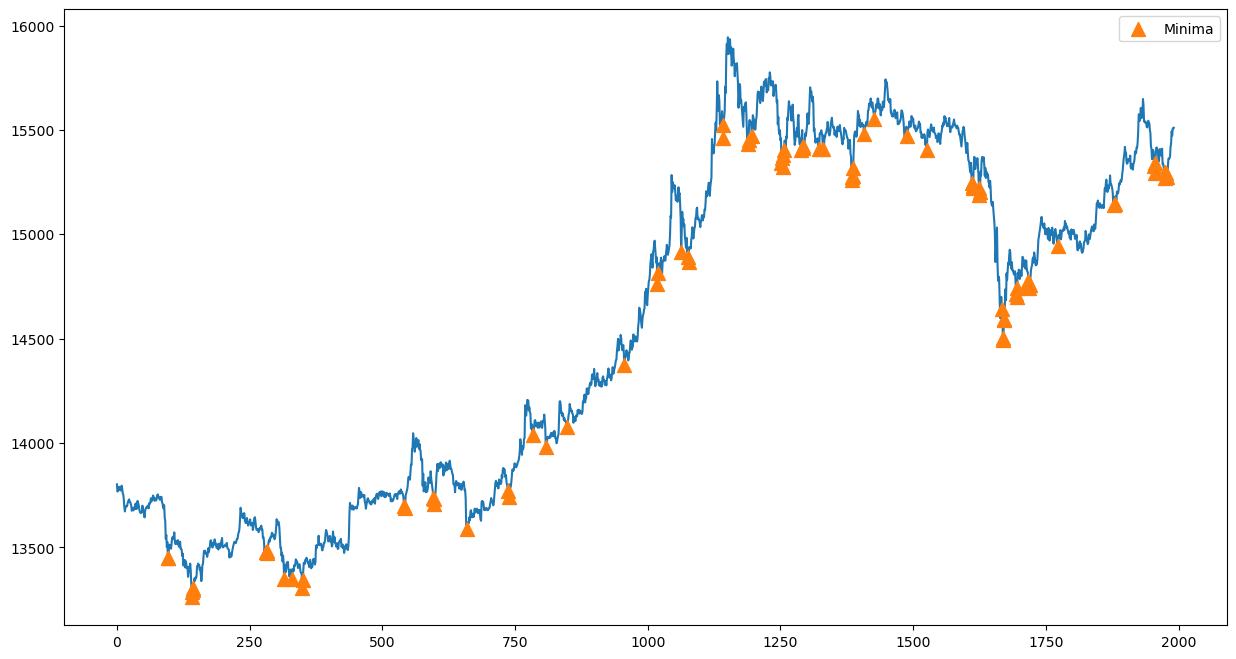

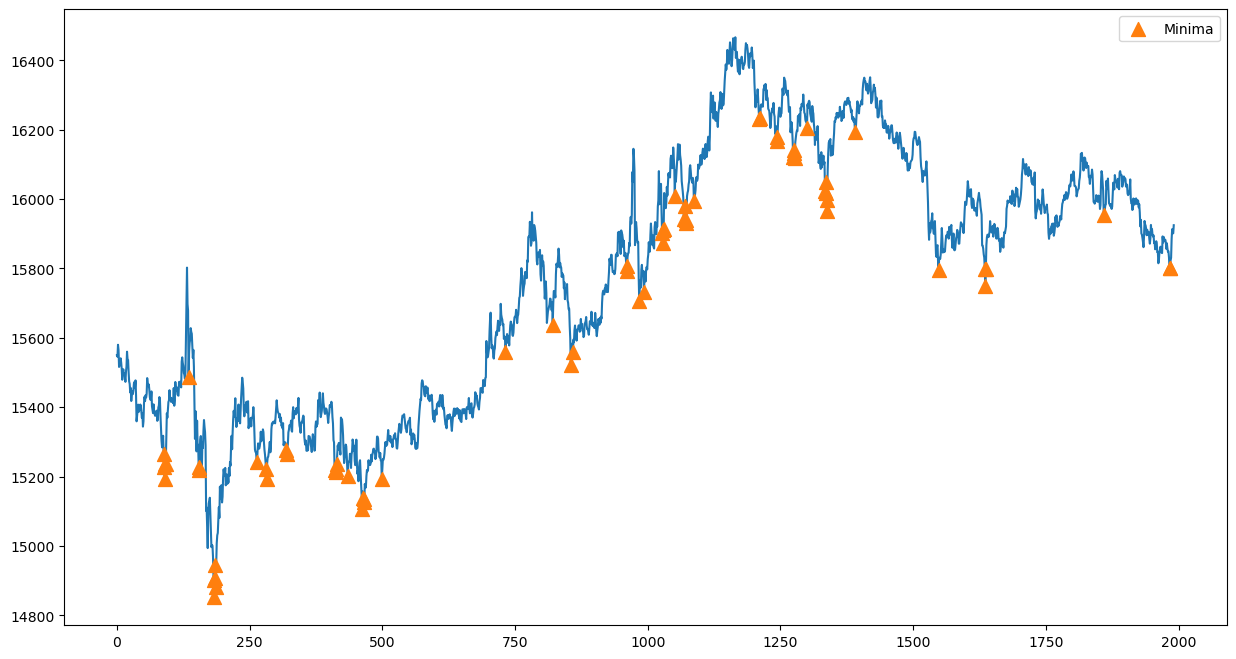

[1911   81]
[1924   68]
23.59259259259259


In [18]:
def calc_labels(labels):
    unique_labels = torch.unique(labels)
    unique_labels, label_counts = np.unique(labels.numpy(), return_counts=True)
    return label_counts 

train_bottoms = find_bottom_point_labels_mean(train_y_gan_cl,classification_label_size)
test_bottoms = find_bottom_point_labels_mean(test_y_gan_cl,classification_label_size)
train_bottom_count = calc_labels(train_bottoms)
test_bottom_count = calc_labels(test_bottoms)
print(train_bottom_count)
print(test_bottom_count)
print(train_bottom_count[0]/train_bottom_count[1])

In [19]:
batch_size = 128
learning_rate = 0.000115
num_epochs = 800
critic_iterations = 5
cl_error_threshold = 0.1
learning_rate_xgboost = 0.3
modelGX_PATH = "modelXG.pth"
modelXGBoost_PATH = 'final_model.model'
use_cuda = 1

device = torch.device("cuda" if (torch.cuda.is_available() & use_cuda) else "cpu")

In [ ]:
modelG = Generator(train_x.shape[1])
modelG.load_state_dict(torch.load("/kaggle/input/wganmodels/wgan_btc.pth",map_location=torch.device('cpu')))
modelG.eval()

_,train_input_features = modelG(train_x_slide.to(device),0)
_,test_input_features = modelG(test_x_slide.to(device),0)
train_input_features = torch.cat((train_input_features, new_feature_tensor_train), dim=2)
test_input_features = torch.cat((test_input_features, new_feature_tensor_test), dim=2)

sx = train_input_features.reshape(train_input_features.shape[0], -1)
sy = train_bottoms
adasyn = ADASYN(sampling_strategy=0.2, random_state=42)
x, y = adasyn.fit_resample(sx.detach().cpu().numpy(), sy.detach().cpu().numpy())
x = torch.tensor(x)
y = torch.tensor(y)
print("After OverSampling, counts of label '0': {}".format(sum(y==0)))
print("After OverSampling, counts of label '1': {}".format(sum(y==1)))

tx = test_input_features.reshape(test_input_features.shape[0], -1)
ty = test_bottoms

In [21]:
spw = train_bottom_count[0]/train_bottom_count[1]


def xgboost_train(n_estimators, max_depth, learning_rate, subsample, colsample_bytree,min_child_weight,reg_alpha,reg_lambda):
    model = xgb.XGBClassifier(
        n_estimators=n_estimators, 
        max_depth=max_depth, 
        learning_rate=learning_rate,
        objective='binary:logistic',
        eval_metric='aucpr',
        subsample = subsample,
        colsample_bytree = colsample_bytree,
        min_child_weight= min_child_weight,
        reg_alpha=reg_alpha,
        reg_lambda=reg_lambda
    )
    model.fit(x.detach().cpu().numpy(),y.detach().cpu().numpy())
    return model

        
def xgboost_test(x,y,xgmodel):
    pred = xgmodel.predict(x.detach().cpu().numpy())
    pred = torch.tensor(pred).reshape(pred.shape[0],1)
    pred_direction = torch.round(pred).int()
    accuracy = f1_score(y.numpy(), pred.numpy())
    precision_score_val = precision_score(y.numpy(), pred.numpy(),zero_division=0)
    recall_score_val = recall_score(y.numpy(), pred.numpy(), average='micro')
    print("F1_score: ", accuracy)
    print("Precision: ",precision_score_val)
    print("Recall_test: ",recall_score_val)
    return precision_score_val

    

In [24]:
def suggest_hyperparameters(trial):
    n_estimators = trial.suggest_int("n_estimators", 100, 1000)
    max_depth = trial.suggest_int("max_depth", 6, 15)
    learning_rate = trial.suggest_float("learning_rate", 0.1, 0.3, log=True)
    subsample = trial.suggest_float("subsample", 0.1, 0.9, step=0.1)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.1, 0.9, step=0.1)
    min_child_weight = trial.suggest_int("min_child_weight", 6, 20)
    reg_alpha = trial.suggest_float("reg_alpha", 0.1, 0.9, step=0.1)
    reg_lambda = trial.suggest_float("reg_lambda", 0.1, 0.9, step=0.1)
    return n_estimators, max_depth, learning_rate, subsample, colsample_bytree,min_child_weight,reg_alpha,reg_lambda


In [25]:
def objective(trial):
    best_recall_val = None
    best_val_loss = float('Inf')
    with mlflow.start_run():

        n_estimators, max_depth, learning_rate, subsample, colsample_bytree,min_child_weight,reg_alpha,reg_lambda = suggest_hyperparameters(trial)
        torch.manual_seed(123)
        mlflow.log_params(trial.params)

        device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        mlflow.log_param("device", device)
        xgboost_model = xgboost_train(n_estimators, max_depth, learning_rate, subsample, colsample_bytree,min_child_weight,reg_alpha,reg_lambda)
        racall_val_train = xgboost_test(sx,sy,xgboost_model)
        recall_val_test = xgboost_test(tx,ty,xgboost_model)
        
        if best_recall_val is None:
            best_recall_val = recall_val_test
        best_recall_val = max(best_recall_val, recall_val_test)
        mlflow.log_metric("recall_test", recall_val_test)

    return best_recall_val

In [ ]:
run_tag = datetime.datetime.now().strftime("%Y-%m-%dT%H:%M")

experiment_id = mlflow.create_experiment(
    f"/Users/myusername/WGAN_Exp_{run_tag}",
    tags={"version": "v1", "priority": "P1"},
)

mlflow.set_experiment(experiment_id=experiment_id)
study = optuna.create_study(study_name=f"WGAN_study_{run_tag}", direction="maximize")
study.optimize(objective, n_trials=300)

[I 2023-04-28 18:37:21,197] A new study created in memory with name: WGAN_study_2023-04-28T18:37
[I 2023-04-28 18:38:16,347] Trial 0 finished with value: 0.946285140562249 and parameters: {'n_estimators': 176, 'max_depth': 10, 'learning_rate': 0.10701902843665408, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.8, 'min_child_weight': 6, 'reg_alpha': 0.7000000000000001, 'reg_lambda': 0.2}. Best is trial 0 with value: 0.946285140562249.


F1_score:  0.8040201005025125
Precision:  0.6779661016949152
Recall_test:  0.9804216867469879
F1_score:  0.144
Precision:  0.15789473684210525
Recall_test:  0.946285140562249


[I 2023-04-28 18:41:12,224] Trial 1 finished with value: 0.9492971887550201 and parameters: {'n_estimators': 859, 'max_depth': 12, 'learning_rate': 0.17419691829831904, 'subsample': 0.5, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 19, 'reg_alpha': 0.9, 'reg_lambda': 0.8}. Best is trial 1 with value: 0.9492971887550201.


F1_score:  0.8852459016393442
Precision:  0.7941176470588235
Recall_test:  0.9894578313253012
F1_score:  0.16528925619834714
Precision:  0.18867924528301888
Recall_test:  0.9492971887550201


[I 2023-04-28 18:43:17,843] Trial 2 finished with value: 0.9513052208835341 and parameters: {'n_estimators': 265, 'max_depth': 15, 'learning_rate': 0.11247250701863103, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.8, 'min_child_weight': 11, 'reg_alpha': 0.6, 'reg_lambda': 0.8}. Best is trial 2 with value: 0.9513052208835341.


F1_score:  0.9418604651162791
Precision:  0.8901098901098901
Recall_test:  0.9949799196787149
F1_score:  0.19834710743801656
Precision:  0.22641509433962265
Recall_test:  0.9513052208835341


[I 2023-04-28 18:43:42,266] Trial 3 finished with value: 0.946285140562249 and parameters: {'n_estimators': 198, 'max_depth': 12, 'learning_rate': 0.12477413468914833, 'subsample': 0.4, 'colsample_bytree': 0.2, 'min_child_weight': 9, 'reg_alpha': 0.6, 'reg_lambda': 0.5}. Best is trial 2 with value: 0.9513052208835341.


F1_score:  0.7766990291262136
Precision:  0.64
Recall_test:  0.9769076305220884
F1_score:  0.17054263565891475
Precision:  0.18032786885245902
Recall_test:  0.946285140562249


[I 2023-04-28 18:43:57,455] Trial 4 finished with value: 0.9432730923694779 and parameters: {'n_estimators': 145, 'max_depth': 10, 'learning_rate': 0.13593778542341658, 'subsample': 0.6, 'colsample_bytree': 0.1, 'min_child_weight': 12, 'reg_alpha': 0.1, 'reg_lambda': 0.2}. Best is trial 2 with value: 0.9513052208835341.


F1_score:  0.8163265306122449
Precision:  0.6956521739130435
Recall_test:  0.9819277108433735
F1_score:  0.15037593984962405
Precision:  0.15384615384615385
Recall_test:  0.9432730923694779


[I 2023-04-28 18:46:24,123] Trial 5 finished with value: 0.9518072289156626 and parameters: {'n_estimators': 417, 'max_depth': 10, 'learning_rate': 0.2562942926790149, 'subsample': 0.6, 'colsample_bytree': 0.9, 'min_child_weight': 7, 'reg_alpha': 0.8, 'reg_lambda': 0.4}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.15789473684210525
Precision:  0.1956521739130435
Recall_test:  0.9518072289156626


[I 2023-04-28 18:47:34,062] Trial 6 finished with value: 0.9196787148594378 and parameters: {'n_estimators': 889, 'max_depth': 10, 'learning_rate': 0.17466518990596638, 'subsample': 0.1, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 12, 'reg_alpha': 0.5, 'reg_lambda': 0.1}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  0.4537313432835821
Precision:  0.2992125984251969
Recall_test:  0.9081325301204819
F1_score:  0.1919191919191919
Precision:  0.14615384615384616
Recall_test:  0.9196787148594378


[I 2023-04-28 18:49:58,727] Trial 7 finished with value: 0.9513052208835341 and parameters: {'n_estimators': 694, 'max_depth': 10, 'learning_rate': 0.20312161764303227, 'subsample': 0.9, 'colsample_bytree': 0.5, 'min_child_weight': 15, 'reg_alpha': 0.1, 'reg_lambda': 0.4}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  0.9938650306748467
Precision:  0.9878048780487805
Recall_test:  0.9994979919678715
F1_score:  0.15652173913043477
Precision:  0.19148936170212766
Recall_test:  0.9513052208835341


[I 2023-04-28 18:51:44,604] Trial 8 finished with value: 0.9467871485943775 and parameters: {'n_estimators': 650, 'max_depth': 11, 'learning_rate': 0.2704816131041895, 'subsample': 0.30000000000000004, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 7, 'reg_alpha': 0.6, 'reg_lambda': 0.8}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  0.9938650306748467
Precision:  0.9878048780487805
Recall_test:  0.9994979919678715
F1_score:  0.171875
Precision:  0.18333333333333332
Recall_test:  0.9467871485943775


[I 2023-04-28 18:52:21,599] Trial 9 finished with value: 0.9513052208835341 and parameters: {'n_estimators': 147, 'max_depth': 6, 'learning_rate': 0.28727226632349384, 'subsample': 0.6, 'colsample_bytree': 0.5, 'min_child_weight': 13, 'reg_alpha': 0.1, 'reg_lambda': 0.5}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  0.903954802259887
Precision:  0.8333333333333334
Recall_test:  0.9914658634538153
F1_score:  0.18487394957983194
Precision:  0.21568627450980393
Recall_test:  0.9513052208835341


[I 2023-04-28 18:54:44,724] Trial 10 finished with value: 0.9492971887550201 and parameters: {'n_estimators': 402, 'max_depth': 7, 'learning_rate': 0.25862698790436056, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 16, 'reg_alpha': 0.9, 'reg_lambda': 0.30000000000000004}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  0.9818181818181818
Precision:  0.9642857142857143
Recall_test:  0.9984939759036144
F1_score:  0.13675213675213674
Precision:  0.16326530612244897
Recall_test:  0.9492971887550201


[I 2023-04-28 18:57:15,885] Trial 11 finished with value: 0.9487951807228916 and parameters: {'n_estimators': 397, 'max_depth': 15, 'learning_rate': 0.21653181448653394, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'reg_alpha': 0.4, 'reg_lambda': 0.7000000000000001}. Best is trial 5 with value: 0.9518072289156626.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.13559322033898305
Precision:  0.16
Recall_test:  0.9487951807228916


[I 2023-04-28 19:00:06,847] Trial 12 finished with value: 0.9523092369477911 and parameters: {'n_estimators': 386, 'max_depth': 15, 'learning_rate': 0.1480697890281241, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 9, 'reg_alpha': 0.8, 'reg_lambda': 0.6}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.9938650306748467
Precision:  0.9878048780487805
Recall_test:  0.9994979919678715
F1_score:  0.17391304347826086
Precision:  0.2127659574468085
Recall_test:  0.9523092369477911


[I 2023-04-28 19:01:37,728] Trial 13 finished with value: 0.9503012048192772 and parameters: {'n_estimators': 453, 'max_depth': 8, 'learning_rate': 0.1415342524166643, 'subsample': 0.9, 'colsample_bytree': 0.30000000000000004, 'min_child_weight': 9, 'reg_alpha': 0.8, 'reg_lambda': 0.6}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.9938650306748467
Precision:  0.9878048780487805
Recall_test:  0.9994979919678715
F1_score:  0.1680672268907563
Precision:  0.19607843137254902
Recall_test:  0.9503012048192772


[I 2023-04-28 19:04:16,776] Trial 14 finished with value: 0.9513052208835341 and parameters: {'n_estimators': 549, 'max_depth': 13, 'learning_rate': 0.15457900945842204, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.6, 'min_child_weight': 7, 'reg_alpha': 0.8, 'reg_lambda': 0.6}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.9938650306748467
Precision:  0.9878048780487805
Recall_test:  0.9994979919678715
F1_score:  0.15652173913043477
Precision:  0.19148936170212766
Recall_test:  0.9513052208835341


[I 2023-04-28 19:06:04,351] Trial 15 finished with value: 0.9523092369477911 and parameters: {'n_estimators': 324, 'max_depth': 8, 'learning_rate': 0.2236235129379761, 'subsample': 0.5, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.9759036144578312
Precision:  0.9529411764705882
Recall_test:  0.9979919678714859
F1_score:  0.2016806722689076
Precision:  0.23529411764705882
Recall_test:  0.9523092369477911


[I 2023-04-28 19:06:48,308] Trial 16 finished with value: 0.9508032128514057 and parameters: {'n_estimators': 268, 'max_depth': 8, 'learning_rate': 0.19898601839483154, 'subsample': 0.4, 'colsample_bytree': 0.4, 'min_child_weight': 10, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.6}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.8804347826086956
Precision:  0.7864077669902912
Recall_test:  0.9889558232931727
F1_score:  0.18333333333333335
Precision:  0.21153846153846154
Recall_test:  0.9508032128514057


[I 2023-04-28 19:08:20,626] Trial 17 finished with value: 0.945281124497992 and parameters: {'n_estimators': 296, 'max_depth': 8, 'learning_rate': 0.15548169488145258, 'subsample': 0.5, 'colsample_bytree': 0.8, 'min_child_weight': 15, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.9}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.8350515463917526
Precision:  0.7168141592920354
Recall_test:  0.9839357429718876
F1_score:  0.15503875968992248
Precision:  0.16393442622950818
Recall_test:  0.945281124497992


[I 2023-04-28 19:08:58,620] Trial 18 finished with value: 0.8649598393574297 and parameters: {'n_estimators': 536, 'max_depth': 14, 'learning_rate': 0.23086183000526114, 'subsample': 0.1, 'colsample_bytree': 0.6, 'min_child_weight': 19, 'reg_alpha': 0.30000000000000004, 'reg_lambda': 0.4}. Best is trial 12 with value: 0.9523092369477911.


F1_score:  0.3412322274881517
Precision:  0.21114369501466276
Recall_test:  0.8604417670682731
F1_score:  0.20648967551622419
Precision:  0.12915129151291513
Recall_test:  0.8649598393574297


[I 2023-04-28 19:12:54,644] Trial 19 finished with value: 0.9533132530120482 and parameters: {'n_estimators': 666, 'max_depth': 9, 'learning_rate': 0.18810284353239196, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'reg_alpha': 0.4, 'reg_lambda': 0.5}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.14678899082568808
Precision:  0.1951219512195122
Recall_test:  0.9533132530120482


[I 2023-04-28 19:16:28,174] Trial 20 finished with value: 0.9497991967871486 and parameters: {'n_estimators': 993, 'max_depth': 13, 'learning_rate': 0.18970650094960062, 'subsample': 0.8, 'colsample_bytree': 0.6, 'min_child_weight': 14, 'reg_alpha': 0.5, 'reg_lambda': 0.7000000000000001}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.13793103448275862
Precision:  0.16666666666666666
Recall_test:  0.9497991967871486


[I 2023-04-28 19:20:04,986] Trial 21 finished with value: 0.9523092369477911 and parameters: {'n_estimators': 670, 'max_depth': 9, 'learning_rate': 0.23087975006543807, 'subsample': 0.8, 'colsample_bytree': 0.9, 'min_child_weight': 10, 'reg_alpha': 0.4, 'reg_lambda': 0.30000000000000004}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.17391304347826086
Precision:  0.2127659574468085
Recall_test:  0.9523092369477911


[I 2023-04-28 19:21:51,239] Trial 22 finished with value: 0.9497991967871486 and parameters: {'n_estimators': 330, 'max_depth': 6, 'learning_rate': 0.18410416183501685, 'subsample': 0.5, 'colsample_bytree': 0.8, 'min_child_weight': 8, 'reg_alpha': 0.2, 'reg_lambda': 0.5}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  0.9818181818181818
Precision:  0.9642857142857143
Recall_test:  0.9984939759036144
F1_score:  0.13793103448275862
Precision:  0.16666666666666666
Recall_test:  0.9497991967871486


[I 2023-04-28 19:26:10,434] Trial 23 finished with value: 0.9497991967871486 and parameters: {'n_estimators': 756, 'max_depth': 9, 'learning_rate': 0.16035225245580556, 'subsample': 0.7000000000000001, 'colsample_bytree': 0.9, 'min_child_weight': 11, 'reg_alpha': 0.4, 'reg_lambda': 0.4}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.16666666666666669
Precision:  0.19230769230769232
Recall_test:  0.9497991967871486


[I 2023-04-28 19:29:09,464] Trial 24 finished with value: 0.9497991967871486 and parameters: {'n_estimators': 495, 'max_depth': 7, 'learning_rate': 0.20524903465214386, 'subsample': 0.9, 'colsample_bytree': 0.8, 'min_child_weight': 10, 'reg_alpha': 0.2, 'reg_lambda': 0.5}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.15254237288135591
Precision:  0.18
Recall_test:  0.9497991967871486


[I 2023-04-28 19:32:23,918] Trial 25 finished with value: 0.9503012048192772 and parameters: {'n_estimators': 618, 'max_depth': 9, 'learning_rate': 0.16710087521900852, 'subsample': 0.8, 'colsample_bytree': 0.7000000000000001, 'min_child_weight': 8, 'reg_alpha': 0.5, 'reg_lambda': 0.30000000000000004}. Best is trial 19 with value: 0.9533132530120482.


F1_score:  1.0
Precision:  1.0
Recall_test:  1.0
F1_score:  0.15384615384615385
Precision:  0.1836734693877551
Recall_test:  0.9503012048192772
